<a href="https://colab.research.google.com/github/GiX7000/deep-learning-with-tensorflow/blob/main/Part11.autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with TensorFlow with Laurence Moroney, Part11

## Example 1. Autoencoders that work on the MNIST dataset. 

This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Prepare the Dataset.

In [ ]:
# define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return image, image
# because the input will also be the target or label while training

def map_image(image, label):
  """Normalizes and flatten the images. Returns image as input and label."""
  image = tf.cast(image, dtype=tf.float32)
  image /= 255.0
  image = tf.reshape(image, shape=(784,))
  return image, image

In [ ]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load("mnist", as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset  = tfds.load("mnist", as_supervised=True, split="test")
test_dataset  = test_dataset.map(map_image)
test_dataset  = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Build the Model 1: a very simple AutoEncoder. 

In [ ]:
# build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output

def simple_autoencoder(inputs):
  """Builds the encoder and decoder using Dense layers"""
  encoder = tf.keras.layers.Dense(units=32, activation="relu")(inputs)
  decoder = tf.keras.layers.Dense(units=784, activation="sigmoid")(encoder)
  return encoder, decoder

# set the input shape
inputs = tf.keras.layers.Input(shape=(784,))  # mnist images are of shape (28,28)

# get the encoder and decoder ouptut
encoder_output, decoder_output = simple_autoencoder(inputs)

# setup the encoder because you will visualize its output later
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

# setup the autoencoder
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

In [ ]:
# compile the model
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy")

# train the model
train_steps = 60000 // BATCH_SIZE
simple_auto_history = autoencoder_model.fit(train_dataset,
                                            steps_per_epoch=train_steps,
                                            epochs=50)

Epoch 1/50
468/468 [==============================] - 9s 18ms/step - loss: 0.2296
Epoch 2/50
468/468 [==============================] - 6s 12ms/step - loss: 0.1413
Epoch 3/50
468/468 [==============================] - 6s 12ms/step - loss: 0.1189
Epoch 4/50
468/468 [==============================] - 10s 21ms/step - loss: 0.1072
Epoch 5/50
468/468 [==============================] - 8s 18ms/step - loss: 0.1009
Epoch 6/50
468/468 [==============================] - 5s 11ms/step - loss: 0.0976
Epoch 7/50
468/468 [==============================] - 5s 10ms/step - loss: 0.0959
Epoch 8/50
468/468 [==============================] - 5s 11ms/step - loss: 0.0950
Epoch 9/50
468/468 [==============================] - 8s 17ms/step - loss: 0.0945
Epoch 10/50
468/468 [==============================] - 6s 12ms/step - loss: 0.0942
Epoch 11/50
468/468 [==============================] - 8s 18ms/step - loss: 0.0940
Epoch 12/50
468/468 [==============================] - 6s 14ms/step - loss: 0.0938
Epoch 13/50


Display sample results.

In [ ]:
# utility functions below will help in plotting the encoded and decoded values

def display_one_row(disp_images, offset, shape=(28, 28)):
  """Display sample outputs in one row."""
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8, 4)):
  """Display the input, encoded, and decoded output values."""
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28, 28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28, 28,))

1/1 [==============================] - 0s 66ms/step


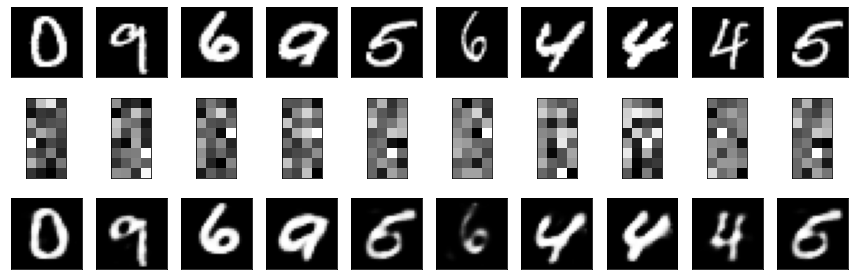

In [ ]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])

Build the Model 2: a deeper network for the AutoEncoder.

In [ ]:
def deep_autoencoder(inputs):
  """Builds the encoder and decoder using Dense layers"""
  encoder = tf.keras.layers.Dense(units=128, activation="relu")(inputs)
  encoder = tf.keras.layers.Dense(units=64,  activation="relu")(encoder)
  encoder = tf.keras.layers.Dense(units=32,  activation="relu")(encoder)

  decoder = tf.keras.layers.Dense(units=64,  activation="relu")(encoder)
  decoder = tf.keras.layers.Dense(units=128, activation="relu")(encoder)
  decoder = tf.keras.layers.Dense(units=784, activation="sigmoid")(encoder)

  return encoder, decoder

# set the input tensor
inputs = tf.keras.layers.Input(shape=(784,))

# get the encoder and decoder output
deep_encoder_output, deep_autoencoder_output = deep_autoencoder(inputs)

# setup the encoder because you will visualize its output later
deep_encoder_model = tf.keras.Model(inputs=inputs, outputs=deep_encoder_output)

# setup the autoencoder
deep_autoencoder_model = tf.keras.Model(inputs=inputs, outputs=deep_autoencoder_output)

In [ ]:
# compile and train the model

train_steps = 60000 // BATCH_SIZE

deep_autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy")

deep_auto_history = deep_autoencoder_model.fit(train_dataset,
                                               steps_per_epoch=train_steps,
                                               epochs=50)

Epoch 1/50
468/468 [==============================] - 8s 15ms/step - loss: 0.2116
Epoch 2/50
468/468 [==============================] - 7s 15ms/step - loss: 0.1311
Epoch 3/50
468/468 [==============================] - 6s 13ms/step - loss: 0.1153
Epoch 4/50
468/468 [==============================] - 6s 13ms/step - loss: 0.1086
Epoch 5/50
468/468 [==============================] - 9s 18ms/step - loss: 0.1043
Epoch 6/50
468/468 [==============================] - 7s 15ms/step - loss: 0.1014
Epoch 7/50
468/468 [==============================] - 6s 12ms/step - loss: 0.0994
Epoch 8/50
468/468 [==============================] - 6s 13ms/step - loss: 0.0978
Epoch 9/50
468/468 [==============================] - 6s 13ms/step - loss: 0.0966
Epoch 10/50
468/468 [==============================] - 6s 13ms/step - loss: 0.0955
Epoch 11/50
468/468 [==============================] - 5s 10ms/step - loss: 0.0947
Epoch 12/50
468/468 [==============================] - 5s 10ms/step - loss: 0.0941
Epoch 13/50
4

Display sample results.

1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


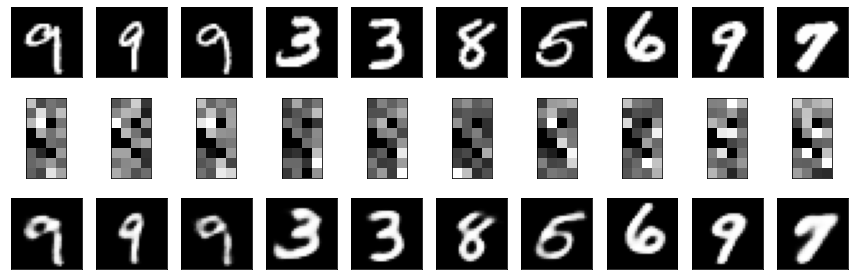

In [ ]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = deep_encoder_model.predict(test_dataset)

# get a prediction for the test batch
deep_predicted = deep_autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], deep_predicted[idxs])

## Example 2. Autoencoders that work on the fashion MNIST dataset. 

1. Here, we will use convolution layers to build our autoencoder. This usually leads to better results than dense networks and we will see it in action with the Fashion MNIST dataset.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Prepare the data.

In [ ]:
# notice that we don't flatten the image this time. That's because we will be using convolutional layers later that can deal with 2D images

def map_image(image, label):
  '''Normalizes the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFXFW33/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFXFW33/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Build the model.

We will use convolutional layers to build the model. This is composed of three main parts: encoder, bottleneck, and decoder.

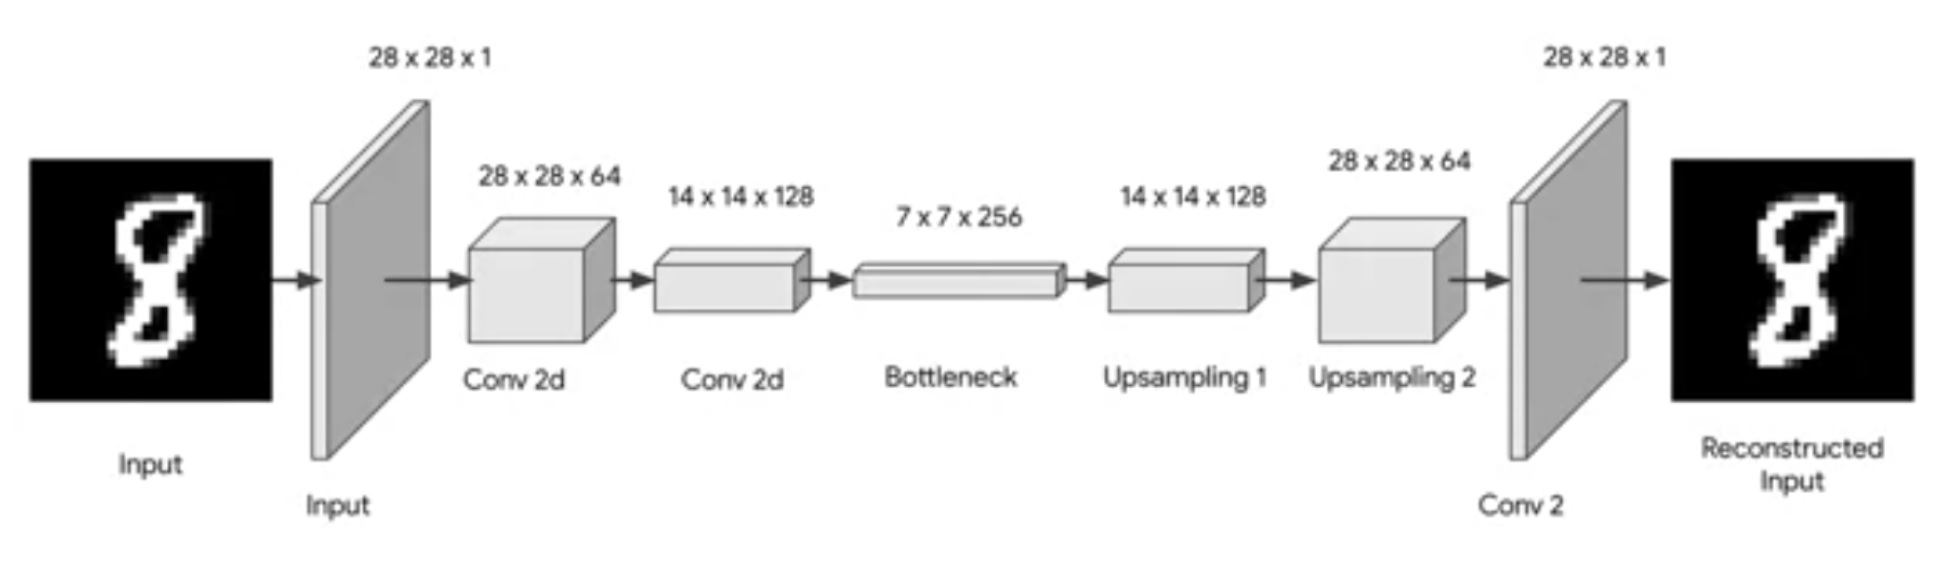

In [ ]:
def encoder(inputs):
  """Defines the encoder with two Conv2D and max pooling layers"""
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                  activation="relu", padding="same")(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3),
                                  activation="relu", padding="same")(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

  return max_pool_2

In [ ]:
# a bottleneck layer is used to get more features but without further reducing the dimension afterwards. Another layer is inserted here for visualizing the encoder output

def bottle_neck(inputs):
  """Defines the bottleneck"""
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3),
                                  activation="relu", padding="same")(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3),
                                                activation="sigmoid", padding="same")(bottle_neck)
  return bottle_neck, encoder_visualization

In [ ]:
def decoder(inputs):
  """Defines the decoder path to upsample back to original image size."""
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3),
                                  activation="relu", padding="same")(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                  activation="relu", padding="same")(up_sample_1)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3),
                                  activation="sigmoid", padding="same")(up_sample_1)
  return conv_3 

In [ ]:
# the full autoencoder
def convolutional_auto_encoder():
  """Builds the entire autoencoder model."""
  inputs = tf.keras.layers.Input(shape=(28, 28, 1))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

  return model, encoder_model

In [ ]:
# let's see it!
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         2951

In [ ]:
# compile and train the model
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40
468/468 [==============================] - 34s 56ms/step - loss: 0.2877 - val_loss: 0.2668
Epoch 2/40
468/468 [==============================] - 24s 51ms/step - loss: 0.2601 - val_loss: 0.2598
Epoch 3/40
468/468 [==============================] - 23s 49ms/step - loss: 0.2555 - val_loss: 0.2558
Epoch 4/40
468/468 [==============================] - 23s 50ms/step - loss: 0.2530 - val_loss: 0.2539
Epoch 5/40
468/468 [==============================] - 24s 51ms/step - loss: 0.2514 - val_loss: 0.2526
Epoch 6/40
468/468 [==============================] - 23s 50ms/step - loss: 0.2504 - val_loss: 0.2518
Epoch 7/40
468/468 [==============================] - 24s 51ms/step - loss: 0.2495 - val_loss: 0.2511
Epoch 8/40
468/468 [==============================] - 23s 49ms/step - loss: 0.2489 - val_loss: 0.2507
Epoch 9/40
468/468 [==============================] - 23s 49ms/step - loss: 0.2485 - val_loss: 0.2505
Epoch 10/40
468/468 [==============================] - 23s 49ms/step - loss: 0.248

Display sample results.

In [ ]:
# let's see some sample results from the trained model

def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 [==============================] - 1s 687ms/step


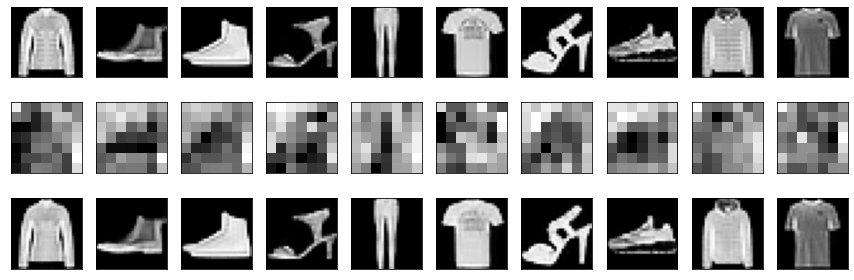

In [ ]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))

2. Denoising with a CNN Autoencoder.

We will introduce noise to the Fashion MNIST dataset and train an autoencoder to reconstruct the original input images.

Prepare the Dataset.

Prepare the train and test sets a little differently this time: instead of just normalizing the images, we will also introduce random noise and the generated images will be used as input to our model. The target or label will still be the clean images.

In [ ]:
def map_image_with_noise(image, label):
  '''Normalizes the images and generates noisy inputs.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  
  noise_factor = 0.5
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
 
  return image_noisy, image

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

We will use the same model as in the above example.

In [ ]:
# compile and train the model
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40
468/468 [==============================] - 34s 71ms/step - loss: 0.2979 - val_loss: 0.2915
Epoch 2/40
468/468 [==============================] - 31s 66ms/step - loss: 0.2874 - val_loss: 0.2882
Epoch 3/40
468/468 [==============================] - 31s 67ms/step - loss: 0.2851 - val_loss: 0.2866
Epoch 4/40
468/468 [==============================] - 30s 64ms/step - loss: 0.2838 - val_loss: 0.2854
Epoch 5/40
468/468 [==============================] - 30s 64ms/step - loss: 0.2830 - val_loss: 0.2846
Epoch 6/40
468/468 [==============================] - 30s 65ms/step - loss: 0.2823 - val_loss: 0.2840
Epoch 7/40
468/468 [==============================] - 31s 67ms/step - loss: 0.2815 - val_loss: 0.2835
Epoch 8/40
468/468 [==============================] - 30s 64ms/step - loss: 0.2812 - val_loss: 0.2831
Epoch 9/40
468/468 [==============================] - 30s 64ms/step - loss: 0.2807 - val_loss: 0.2825
Epoch 10/40
468/468 [==============================] - 30s 64ms/step - loss: 0.280

Display sample results.

1/1 [==============================] - 0s 68ms/step


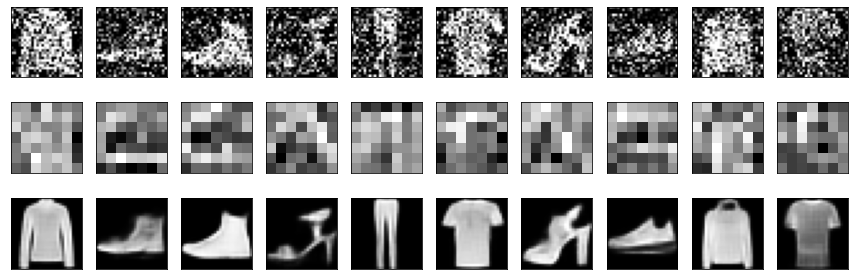

In [ ]:
# Let's see if the model can generate the clean image from noisy inputs
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))

## Example 3. A simple convolutional AutoEncoder on CIFAR-10 dataset.

We will create a convolutional autoencoder for the CIFAR10 dataset.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.models import Sequential

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Load and prepare the dataset.

In [ ]:
# preprocessing function
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image # dataset label is not used. replaced with the same image input.

# parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

# use tfds.load() to fetch the 'train' split of CIFAR-10
train_dataset = tfds.load('cifar10', split='train', as_supervised=True)

# preprocess the dataset with the `map_image()` function above
train_dataset = train_dataset.map(map_image)

# shuffle and batch the dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


# use tfds.load() to fetch the 'test' split of CIFAR-10
test_dataset = tfds.load('cifar10', split='test', as_supervised=True)

# preprocess the dataset with the `map_image()` function above
test_dataset = test_dataset.map(map_image)

# batch the dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteALU2HX/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteALU2HX/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Build the model.

We will want to downsample the image in the encoder layers then upsample it in the decoder path. Note that the output layer should be the same dimensions as the original image. Our input images will have the shape (32, 32, 3).

In [ ]:
from keras.layers import Conv2D, UpSampling2D
from keras import backend as K 

K.clear_session()

# use the Sequential API (you can remove if you want to use the Functional API)
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu", input_shape=(32, 32, 3))) # (16, 16, 64)
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")) # (8, 8, 128)

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")) # (8, 8, 256)

model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")) # (16, 16, 128)
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")) # (32, 32, 64)
model.add(UpSampling2D(size=(2, 2)))

model.add(Conv2D(filters=3, kernel_size=(3, 3), padding="same", activation="sigmoid")) # (32, 32, 1)

# compile the model
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        73792     
                                                        

In [ ]:
# train the model
train_steps = len(train_dataset) // BATCH_SIZE 
val_steps = len(test_dataset) // BATCH_SIZE

model.fit(train_dataset, 
          steps_per_epoch=train_steps, 
          validation_data=test_dataset,
          validation_steps=val_steps, 
          epochs=50)

Epoch 1/50
3/3 [==============================] - 1s 45ms/step - loss: 0.0627 - accuracy: 0.4129
Epoch 2/50
3/3 [==============================] - 0s 34ms/step - loss: 0.0557 - accuracy: 0.4121
Epoch 3/50
3/3 [==============================] - 0s 40ms/step - loss: 0.0570 - accuracy: 0.4616
Epoch 4/50
3/3 [==============================] - 1s 347ms/step - loss: 0.0401 - accuracy: 0.3162
Epoch 5/50
3/3 [==============================] - 0s 37ms/step - loss: 0.0336 - accuracy: 0.4451
Epoch 6/50
3/3 [==============================] - 0s 33ms/step - loss: 0.0487 - accuracy: 0.4785
Epoch 7/50
3/3 [==============================] - 0s 34ms/step - loss: 0.0412 - accuracy: 0.3858
Epoch 8/50
3/3 [==============================] - 0s 40ms/step - loss: 0.0412 - accuracy: 0.4300
Epoch 9/50
3/3 [==============================] - 0s 38ms/step - loss: 0.0322 - accuracy: 0.4429
Epoch 10/50
3/3 [==============================] - 0s 40ms/step - loss: 0.0269 - accuracy: 0.5080
Epoch 11/50
3/3 [===========

In [ ]:
# evaluate the model
result = model.evaluate(test_dataset, steps=10)

10/10 [==============================] - 0s 17ms/step - loss: 0.0061 - accuracy: 0.7579
